# CmdStanPy Tutorial


### Workflow Outline

Given a dataset and a model specification written as a Stan program, the CmdStanPy workflow is:

#### Assemble input data as either:
  + A Python `dict` object consisting of key-value pairs where the key corresponds
 to Stan data variables and the value is of the correct type and shape.
  + An existing data file on disk in either JSON or Rdump format.

#### Compile Stan program: function `compile_model`
  + Takes as input a Stan program and produces the corresponding c++ executable.
  + Returns `Model` object which wraps program, c++ executable filenames or raises exception.
  + Both Stan program and c++ executable stored on disk.

#### Run sampler: function `sample`
  + Invokes Stan's NUTS-HMC sampler to condition model on input data, produces output csv files.
  + Creates lightweight object `RunSet` which wraps sampler arguments, per-chain outcome, output files.
  + Runs any number of chains - default is 4 chains.
  + Validates that all chains run to completion, produce expected number of draws.
  + Returns `RunSet` if sample is valid, else raises exception.

#### Assemble fit in-memory: function `get_drawset`
  + Sampler output consists of csv files
  + `RunSet` method `assemble_sample` reads sampler output csv files into 3-D numpy ndarray (draws, chains, columns)
  + Function `get_drawset` flattens chains, returns a pandas DataFrame one row per draw, one column per parameters.
  + `get_drawset` argument `params` filters DataFrame columns by list of parameter names.

#### Summarize posterior fit:  function `summary`
  + Invokes CmdStan's `bin/stansummary` utility
  + Returns a Pandas DataFrame with estimates of posterior means, standard deviations, Monte-Carlo standard error, effective sample size, and convergence diagnostic statistic for all parameters in the model.

#### Check for problems: function `diagnose`
  + Invokes CmdStan's `bin/diagnose` utility
  + Prints output to console
  + Checks for following problems:
    + transitions that hit the maximum treedepth
    + divergent transitions
    + low E-BFMI values (sampler transitions HMC potential energy)
    + low effective sample sizes
    + high R-hat values


### Installation

* Install Python package from PyPI or directly from GitHub:

  + `pip install --upgrade cmdstanpy`
  + `pip install -e git+https://github.com/stan-dev/cmdstanpy`


* CmdStanPy uses CmdStan directly to compile and run Stan programs, therefore CmdStan must be installed locally.

  + if you have a working installation of CmdStan, set environment variable `CMDSTAN` to the full path to the top-level CmdStan directory.
  
  + if you don't already have CmdStan installed, run Python script `install_cmdstan` which downloads and compiles the latest release from https://github.com/stan-dev/cmdstan/releases.  By default this installs the latest version of CmdStan in the location `~/.cmdstanpy`.  Flags -d and -v are used to specify the directory and version, respectively.


### Example 1:  Compile and run CmdStan example model `bernoulli.stan`, data `bernoulli.data.json`

Every CmdStan release has an `examples/bernoulli` directory which contains the Stan model and test data files.  In this example we compile the model and run the sampler on the model and data.

##### Import relevant classes and methods

In [1]:
import os
import os.path
from cmdstanpy import cmdstan_path, compile_model, sample, get_drawset, summary, diagnose

##### Compile model, specify data or data file

The CmdStanPy directory `examples/bernoulli` contains the model and data files.

In [5]:
bernoulli_path = os.path.join(cmdstan_path(), 'examples', 'bernoulli')
bernoulli_stan = os.path.join(bernoulli_path, 'bernoulli.stan')

The `compile_model` functions compiles the Stan program and returns a `Model` object.

In [7]:
bernoulli_model = compile_model(bernoulli_stan)
print(bernoulli_model)

Model(name=bernoulli,  stan_file="/Users/mitzi/.cmdstanpy/cmdstan-2.19.1/examples/bernoulli/bernoulli.stan", exe_file="/Users/mitzi/.cmdstanpy/cmdstan-2.19.1/examples/bernoulli/bernoulli")


Input data is either a Python `Dict` with entries corresponding to input data values, or it can be a file in JSON or Rdump format.

In [8]:
bern_json = os.path.join(bernoulli_path, 'bernoulli.data.json')

If a `Dict` is specified, CmdStanPy writes it to a temp file in JSON format.

In [9]:
bern_data = { "N" : 10, "y" : [0,1,0,0,0,0,0,0,0,1] }

##### Run the HMC-NUTS sampler on the model and data

The `sample` function runs the NUTS-HMC sampler and returns a `RunSet` object.

In [28]:
bern_fit = sample(bernoulli_model, data=bern_data)

input data tempfile: /var/folders/sc/0f0wdc_11_xgjs2v52g20fvr0000gn/T/tmpggqfg6d4/tmpjvatu0sj.json
start chain 1.  
finish chain 1.  
start chain 2.  
finish chain 2.  
start chain 3.  
finish chain 3.  
start chain 4.  
finish chain 4.  


By default, the sample function runs 4 sampler chains.  The `chains` argument specifies the number of chains to run.  The `cores` argument specifies the number of processes to run in parallel.

In [29]:
bern_fit = sample(bernoulli_model, chains=5, cores=3, data=bern_data)

input data tempfile: /var/folders/sc/0f0wdc_11_xgjs2v52g20fvr0000gn/T/tmpggqfg6d4/tmp0f38xgj5.json
start chain 1.  start chain 2.  start chain 3.  


finish chain 3.  
start chain 4.  
finish chain 1.  
finish chain 2.  start chain 5.  

finish chain 4.  
finish chain 5.  


##### Summarize or save the results

The `summary` function returns output of CmdStan bin/stansummary as pandas.DataFrame:

In [30]:
summary(bern_fit)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-7.261820,0.018652,0.757622,-8.702790,-6.978630,-6.749400,1649.96,9970.79,1.00165
theta,0.250187,0.002734,0.119040,0.082719,0.237129,0.467633,1895.30,11453.40,1.00041


The `diagnose` function prints diagnostics to console:

In [31]:
diagnose(bern_fit)

No problems detected.


The `get_drawset` function returns a pandas.DataFrame, one draw per row.

In [32]:
bern_drawset = get_drawset(bern_fit)

By default, `get_drawset` returns a DataFrame which contains all columns from the sampler's csv output file, i.e., it contains both the sampler state and the values for all parameter, transformed parameter, and generated quantities variables.

In [33]:
bern_drawset.shape, bern_drawset.columns

((5000, 8),
 Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
        'divergent__', 'energy__', 'theta'],
       dtype='object'))

The `get_drawset` function argument `params` takes a list of parameter or column names:

In [34]:
thetas = get_drawset(bern_fit, params=['theta'])
thetas.shape


(5000, 1)

In [35]:
thetas[0:3]

,theta
0,0.177184
1,0.171893
2,0.551869


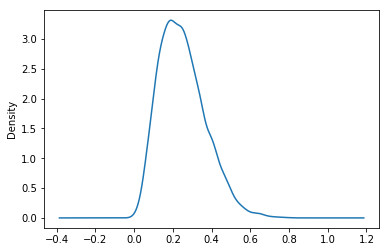

In [36]:
bern_drawset.theta.plot.density()

### Access to sampler output via `RunSet ` methods and attributes

#### sample

The `sample` property is a 3-D numpy ndarray which contains all draws across all chains.  This array is created only as needed; therefore the first time that this property is accessed CmdStanPy will read in the contents of the sampler's csv output files.  Because the csv output files also contain stepsize and metric information, the `stepsize` and `metric` arrays will also be created.

The ndarray is stored column major format so that values for each parameter are stored contiguously in memory, likewise all draws from a chain are contiguous.  Thus the dimensions of the ndarray are arranged as follows:  (draws, chains, columns):

In [37]:
bern_fit.sample
bern_fit.sample.shape

(1000, 5, 8)

Python's index slicing operations can be used to access the information by chain.
For example, to select all draws and all output columns from the first chain,
we specify the chain index (2nd index dimension).  As arrays indexing starts at 0,
the index '0' corresponds to the first chain in the ``RunSet``.

The following expression selects the first 3 draws from chain 1 for the parameter `theta`:

In [38]:
bern_fit.column_names[7], bern_fit.sample[0:3,0,7]

('theta', array([0.177184, 0.171893, 0.551869]))

#### stepsize

The `stepsize` property is a 1-D numpy ndarray which contains the stepsize used by the sampler for each chain.  This array is created at the same time as the `sample` and `metric` arrays are created.

At the end of adaptation, the stepsize for the 4 chains in this example is:

In [39]:
bern_fit.stepsize

array([1.39734 , 1.27207 , 0.956467, 0.804156, 0.867051])

#### metric_type, metric

The `metric` property is an numpy ndarray which contains the metric used by the sampler for each chain.  This array is created at the same time as the `sample` and `stepsize` arrays are created.

At the end of adaptation, the metric for the 4 chains in this example is:

In [40]:
bern_fit.metric_type,  bern_fit.metric

('diag_e', array([[0.444845],
        [0.441921],
        [0.609734],
        [0.610979],
        [0.566994]]))